<a href="https://colab.research.google.com/github/Nmg1994/Crop_yield_prediction/blob/main/Crop%20yield%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing necessary packages

In [ ]:
!pip install rasterio
!pip install scikit-learn xgboost lightgbm optuna
!pip install statsmodels

# Importing necessary libraries/modules

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Preparing the variables before feeding them into the models

In [ ]:
# Importing the dataframe including the soil characteristics and yields' values
Soil_and_Crop_yields_2021_old_order = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Soil_and_Crop_yields_2021.xlsx')
Soil_and_Crop_yields_2021_old_order.drop(columns = ['OBJECTID *', 'Shape *',	'New_ID *','Shape_Length', 'Shape_Area', 'OBJECTID', 'CCSUID', 'CCSNAME', 'SRUNOM','Shape_Length.1', 'Shape_Area.1'], axis=1, inplace=True)

# New column order
new_order = ['New_ID', 'MEAN_BASES_N', 'MEAN_BD_N', 'MEAN_CEC_N', 'MEAN_KP0_N',
       'MEAN_KP1500_N', 'MEAN_KP33_N', 'MEAN_KSAT_N', 'MEAN_ORGCARB_N',
       'MEAN_PHCA_N', 'MEAN_TCLAY_N', 'MEAN_TSAND_N', 'MEAN_TSILT_N',
       'CANOLA_M', 'SOYBNS_M', 'ALFALFA_M', 'APPLETA_M', 'STRWBTA_M',
       'RASPBTA_M', 'CRANBTA_M', 'BLUEBTA_M', 'VALUE']

# Reordering the columns
Soil_and_Crop_yields_2021 = Soil_and_Crop_yields_2021_old_order.reindex(columns=new_order)

In [ ]:
# Filling the CCS lacking EVI and NDVI based on their minimum and maximum values
def fill_na(row):
  if pd.isna(row['MIN']):
    return (row['MAX'])
  elif pd.isna(row['MAX']):
    return (row['MIN'])
  elif pd.isna(row['MEAN']):
    return (row['MIN'] + row['MAX']) / 2
  else:
    return row['MEAN']

Soil_and_Crop_yields = Soil_and_Crop_yields_2021.copy()

Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']

for m in tqdm(range(len(Months)), desc="Processing"):
  EVI = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/EVI_{Months[m]}.xlsx')
  NDVI = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/NDVI_{Months[m]}.xlsx')
  Air_min = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Air_min_{Months[m]}.xlsx')
  Air_max = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Air_max_{Months[m]}.xlsx')
  Air_avg = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Air_avg_{Months[m]}.xlsx')
  Precip = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Precip_{Months[m]}.xlsx')

  # Applying the fill_na function on EVI and NDVI
  EVI[f'MEAN_EVI_{Months[m]}'] = EVI.apply(fill_na, axis=1)
  NDVI[f'MEAN_NDVI_{Months[m]}'] = NDVI.apply(fill_na, axis=1)

  Air_min[f'MEAN_Air_min_{Months[m]}'] = Air_min['MEAN']
  Air_max[f'MEAN_Air_max_{Months[m]}'] = Air_max['MEAN']
  Air_avg[f'MEAN_Air_avg_{Months[m]}'] = Air_avg['MEAN']
  Precip[f'MEAN_Precip_{Months[m]}'] = Precip['MEAN']

  EVI = EVI.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  NDVI = NDVI.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Air_min = Air_min.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Air_max = Air_max.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Air_avg = Air_avg.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Precip = Precip.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)

  # Performing a left join
  Soil_and_Crop_yields = pd.merge(Soil_and_Crop_yields, EVI, on='New_ID', how='left')
  Soil_and_Crop_yields = pd.merge(Soil_and_Crop_yields, NDVI, on='New_ID', how='left')
  Soil_and_Crop_yields = pd.merge(Soil_and_Crop_yields, Air_min, on='New_ID', how='left')
  Soil_and_Crop_yields = pd.merge(Soil_and_Crop_yields, Air_max, on='New_ID', how='left')
  Soil_and_Crop_yields = pd.merge(Soil_and_Crop_yields, Air_avg, on='New_ID', how='left')
  Soil_and_Crop_yields = pd.merge(Soil_and_Crop_yields, Precip, on='New_ID', how='left')

Soil_and_Crop_yields.to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_2021.xlsx', index=False)

Processing: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]


In [ ]:
All_variables_2021 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_2021.xlsx')
All_variables_2021 = All_variables_2021.drop(columns = ['RASPBTA_M', 'CRANBTA_M'], axis=1) # Raspberries and Cranberries were removed due to the small data size

Crops = ['CANOLA_M', 'SOYBNS_M', 'ALFALFA_M', 'APPLETA_M', 'STRWBTA_M', 'BLUEBTA_M']
# Removing CCS with zero yields for all the crops; if there would be a CCS with the yields zero for all the crops, it will be removed from further investigation
def removing_CCS_with_zero_yields_for_all_crops(DF, Crops):
  for croptype in Crops:
    DF.loc[DF[croptype] == -1, croptype] = 0

  df = DF[(DF[Crops[0]] != 0) | (DF[Crops[1]] != 0) | (DF[Crops[2]] != 0) | (DF[Crops[3]] != 0) | (DF[Crops[4]] != 0) | (DF[Crops[5]] != 0)].reset_index(drop=True)
  return df

CCS_with_yields = removing_CCS_with_zero_yields_for_all_crops(All_variables_2021, Crops)

In [ ]:
def preprocessing_function(df):
  CCS_ID = df['New_ID'].drop_duplicates().to_numpy()
  Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']

  Constant_variables = pd.DataFrame()
  Constant_variables = df[['New_ID', 'MEAN_BASES_N', 'MEAN_BD_N', 'MEAN_CEC_N', 'MEAN_KP0_N',
       'MEAN_KP1500_N', 'MEAN_KP33_N', 'MEAN_KSAT_N', 'MEAN_ORGCARB_N',
       'MEAN_PHCA_N', 'MEAN_TCLAY_N', 'MEAN_TSAND_N', 'MEAN_TSILT_N',
       'CANOLA_M', 'SOYBNS_M', 'ALFALFA_M', 'APPLETA_M', 'STRWBTA_M',
       'BLUEBTA_M', 'VALUE']]

  # List of new column names
  new_column_names = ['New_ID', 'Base saturation', 'Bulk density', 'Cation exchange capacity', 'Water retention KP0',
        'Water retention KP1500', 'Water retention KP33', 'Saturated hydraulic conductivity', 'Soil organic carbon',
        'PH', 'Clay', 'Sand', 'Silt', 'Canola','Soybeans',
        'Alfalfa', 'Apples', 'Strawberries', 'Blueberries', 'Honeybee colonies']

  # Assigning new column names
  Constant_variables.columns = new_column_names

  for m in tqdm(range(len(Months)), desc = 'Month processing'):
    if m == 0:
      df_prepared = pd.DataFrame()
      for id_index in CCS_ID:
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Months'] = 5
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'EVI'] = df.loc[df['New_ID'] == id_index, f'MEAN_EVI_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'NDVI'] = df.loc[df['New_ID'] == id_index, f'MEAN_NDVI_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Minimum temperature'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_min_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Maximum temperature'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Mean temperature'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_avg_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Precipitation'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_{Months[m]}'].values[0]

      df_prepared = pd.concat([df_prepared, Constant_variables], axis = 0, ignore_index=True)
    else:
      for id_index in CCS_ID:
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Months'] = m + 5
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'EVI'] = df.loc[df['New_ID'] == id_index, f'MEAN_EVI_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'NDVI'] = df.loc[df['New_ID'] == id_index, f'MEAN_NDVI_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Minimum temperature'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_min_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Maximum temperature'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Mean temperature'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_avg_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Precipitation'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_{Months[m]}'].values[0]

      df_prepared = pd.concat([df_prepared, Constant_variables], axis = 0, ignore_index=True)

  df_prepared.to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_prepared_2021.xlsx', index=False)
  pd.DataFrame(CCS_ID, columns=['New_ID']).to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/CCS_ID.xlsx', index=False)

preprocessing_function(CCS_with_yields)

# Spearman correlation analyses

In [ ]:
All_variables_prepared_2021 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_prepared_2021.xlsx')

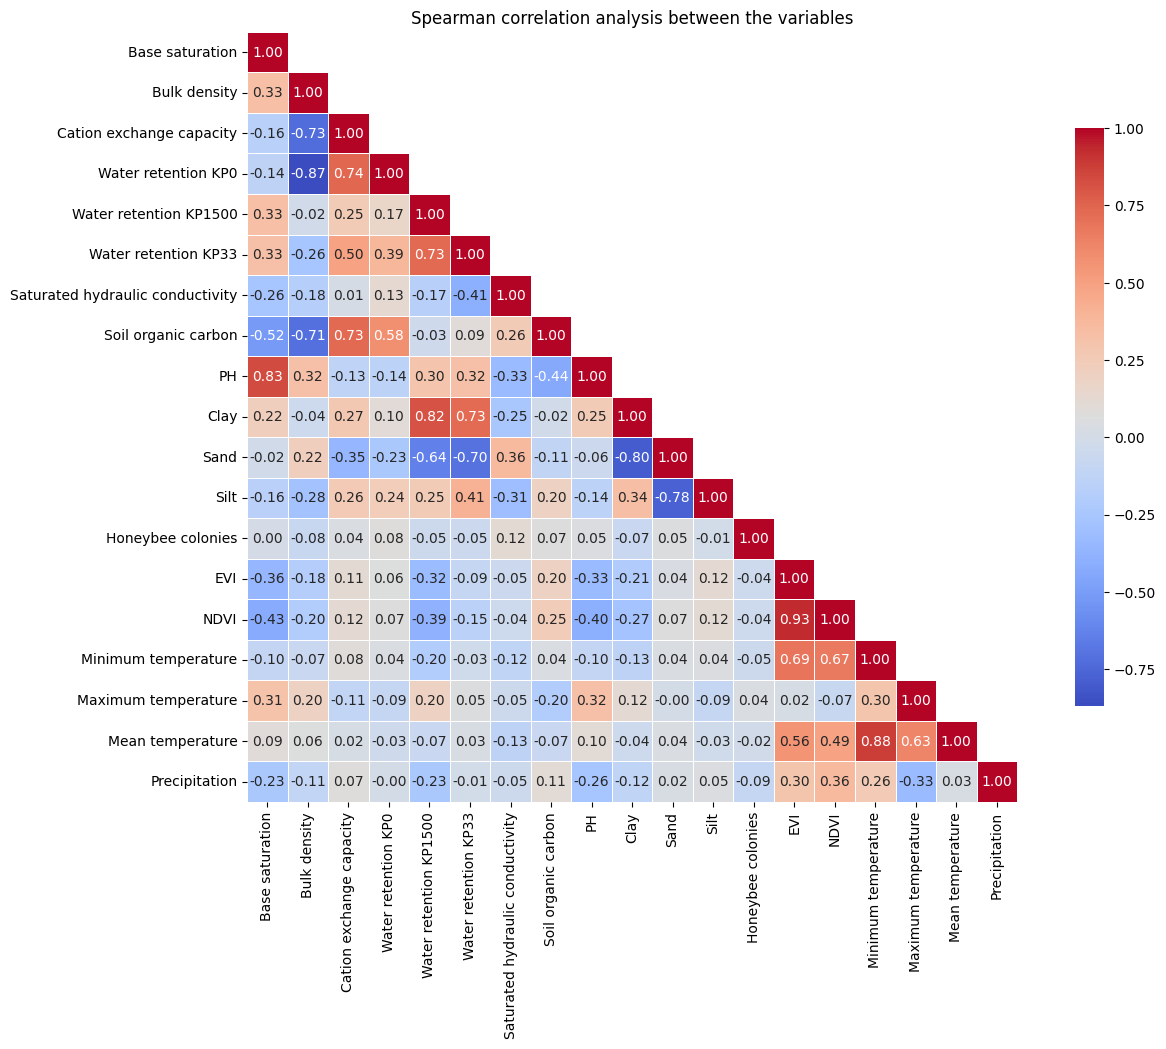

In [ ]:
var_2021 = All_variables_prepared_2021.drop(columns = ['New_ID','Months','Canola', 'Soybeans', 'Alfalfa', 'Apples', 'Strawberries', 'Blueberries'], axis=1)

# Calculating the Spearman correlation matrix
corr_matrix = var_2021.corr(method='spearman')

# Masking the upper triangle excluding the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Setting up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plotting the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": 0.75}, linewidths=0.5)

plt.title('Spearman correlation analysis between the variables')
plt.show()

In [ ]:
# Calculating VIF and Tolerance
def calculate_vif(df):
  # Adding a constant column for the intercept
  df_with_constant = sm.add_constant(df)

  # Calculating VIF for each feature
  vif_data = pd.DataFrame()
  vif_data['Feature'] = df.columns
  vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i+1) for i in range(len(df.columns))]
  vif_data['Tolerance'] = 1 / vif_data['VIF']

  return vif_data

# Using the function to calculate VIF and Tolerance
vif_df = calculate_vif(var_2021)

# Formatting VIF and Tolerance values for better readability
vif_df['VIF'] = vif_df['VIF'].map('{:.2f}'.format)
vif_df['Tolerance'] = vif_df['Tolerance'].map('{:.2f}'.format)

print(vif_df)

                             Feature           VIF     Tolerance
0                    Base saturation  4.169348e+00  2.398457e-01
1                       Bulk density  8.924222e+00  1.120546e-01
2           Cation exchange capacity  6.344688e+00  1.576122e-01
3                Water retention KP0  7.611010e+00  1.313886e-01
4             Water retention KP1500  3.856891e+00  2.592762e-01
5               Water retention KP33  5.097559e+00  1.961723e-01
6   Saturated hydraulic conductivity  1.637291e+00  6.107649e-01
7                Soil organic carbon  6.206740e+00  1.611152e-01
8                                 PH  4.389465e+00  2.278182e-01
9                               Clay  1.801440e+15  5.551115e-16
10                              Sand  4.503600e+15  2.220446e-16
11                              Silt  2.251800e+15  4.440892e-16
12                 Honeybee colonies  1.037910e+00  9.634742e-01
13                               EVI  8.782803e+00  1.138589e-01
14                       

# Climate change scenarios data preparation before the interpolation in ArcGIS Pro

In [ ]:
for g in tqdm(range(1,7), desc='Progress: '):
  T_avg = pd.read_csv(f'/content/drive/My Drive/Climate_change_scenarios_Canada/tg_mean_{g}.csv')
  T_max = pd.read_csv(f'/content/drive/My Drive/Climate_change_scenarios_Canada/tx_mean_{g}.csv')
  T_min = pd.read_csv(f'/content/drive/My Drive/Climate_change_scenarios_Canada/tn_mean_{g}.csv')
  Prec = pd.read_csv(f'/content/drive/My Drive/Climate_change_scenarios_Canada/prcptot_{g}.csv')

  T_avg_df = T_avg[['time','lat','lon', 'ssp126_tg_mean_p50', 'ssp245_tg_mean_p50', 'ssp585_tg_mean_p50']]
  T_max_df = T_max[['time','lat','lon', 'ssp126_tx_mean_p50', 'ssp245_tx_mean_p50', 'ssp585_tx_mean_p50']]
  T_min_df = T_min[['time','lat','lon', 'ssp126_tn_mean_p50', 'ssp245_tn_mean_p50', 'ssp585_tn_mean_p50']]
  Prec_df = Prec[['time','lat','lon', 'ssp126_prcptot_p50', 'ssp245_prcptot_p50', 'ssp585_prcptot_p50']]

  T_avg_df_2026 = T_avg_df[T_avg_df['time'].str.contains('2026', na=False)].reset_index(drop=True)
  T_max_df_2026 = T_max_df[T_max_df['time'].str.contains('2026', na=False)].reset_index(drop=True)
  T_min_df_2026 = T_min_df[T_min_df['time'].str.contains('2026', na=False)].reset_index(drop=True)
  Prec_df_2026 = Prec_df[Prec_df['time'].str.contains('2026', na=False)].reset_index(drop=True)

  Coordinates = Prec_df_2026[['lat','lon']].drop_duplicates(subset=['lat', 'lon']).reset_index(drop=True)

  DF_2026 = pd.DataFrame()

  for ind in range(len(Coordinates)):
    latitude = Coordinates['lat'][ind]
    longitude = Coordinates['lon'][ind]

    Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']
    scenarios = ['126', '245', '585']
    # List of substrings
    substrings = ['2026-05', '2026-06', '2026-07', '2026-08', '2026-09']

    # Creating a regex pattern from the list of substrings
    pattern = '|'.join(substrings)

    T_avg_df_2026_May_Sep = T_avg_df_2026[(T_avg_df_2026['time'].str.contains(pattern, na=False)) & (T_avg_df_2026['lat'] == latitude) & (T_avg_df_2026['lon'] == longitude)].reset_index(drop=True)
    T_max_df_2026_May_Sep = T_max_df_2026[(T_max_df_2026['time'].str.contains(pattern, na=False)) & (T_max_df_2026['lat'] == latitude) & (T_max_df_2026['lon'] == longitude)].reset_index(drop=True)
    T_min_df_2026_May_Sep = T_min_df_2026[T_min_df_2026['time'].str.contains(pattern, na=False) & (T_min_df_2026['lat'] == latitude) & (T_min_df_2026['lon'] == longitude)].reset_index(drop=True)
    Prec_df_2026_May_Sep = Prec_df_2026[(Prec_df_2026['time'].str.contains(pattern, na=False)) & (Prec_df_2026['lat'] == latitude) & (Prec_df_2026['lon'] == longitude)].reset_index(drop=True)

    DF_2026.loc[ind,'lat'] = latitude
    DF_2026.loc[ind,'lon'] = longitude

    for s in range(len(scenarios)):
      for m in range(len(Months)):
        DF_2026.loc[ind, f'T_avg_{scenarios[s]}_{Months[m]}']= T_avg_df_2026_May_Sep[f'ssp{scenarios[s]}_tg_mean_p50'].values[m]
        DF_2026.loc[ind, f'T_max_{scenarios[s]}_{Months[m]}']= T_max_df_2026_May_Sep[f'ssp{scenarios[s]}_tx_mean_p50'].values[m]
        DF_2026.loc[ind, f'T_min_{scenarios[s]}_{Months[m]}']= T_min_df_2026_May_Sep[f'ssp{scenarios[s]}_tn_mean_p50'].values[m]
        DF_2026.loc[ind, f'Prec_{scenarios[s]}_{Months[m]}']= Prec_df_2026_May_Sep[f'ssp{scenarios[s]}_prcptot_p50'].values[m]

  if g == 1:
    DF_2026_all_stations_Canada = DF_2026
  else:
    DF_2026_all_stations_Canada = pd.concat([DF_2026_all_stations_Canada, DF_2026], axis = 0, ignore_index=True)

DF_2026_all_stations_Canada.to_csv('/content/drive/My Drive/Climate_change_scenarios_Canada/DF_2026_all_stations_Canada.csv', index= False)

# Climate change dataframe preparation after preprocessing the data in ArcGIS Pro

In [ ]:
# Getting the soil characteristics from the year 2021, assuming the soil characteristics remain unchanged
Soil_and_Crop_yields_2021_old_order = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Soil_and_Crop_yields_2021.xlsx')
Soil_and_Crop_yields_2021_old_order.drop(columns = ['OBJECTID *', 'Shape *',	'New_ID *','Shape_Length', 'Shape_Area', 'OBJECTID', 'CCSUID', 'CCSNAME', 'SRUNOM','Shape_Length.1', 'Shape_Area.1'], axis=1, inplace=True)

# New column order
new_order = ['New_ID', 'MEAN_BASES_N', 'MEAN_BD_N', 'MEAN_CEC_N', 'MEAN_KP0_N',
       'MEAN_KP1500_N', 'MEAN_KP33_N', 'MEAN_KSAT_N', 'MEAN_ORGCARB_N',
       'MEAN_PHCA_N', 'MEAN_TCLAY_N', 'MEAN_TSAND_N', 'MEAN_TSILT_N',
       'CANOLA_M', 'SOYBNS_M', 'ALFALFA_M', 'APPLETA_M', 'STRWBTA_M',
       'RASPBTA_M', 'CRANBTA_M', 'BLUEBTA_M', 'VALUE']

# Reordering the columns
Soil_and_Crop_yields_2021 = Soil_and_Crop_yields_2021_old_order.reindex(columns=new_order)

Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']

Soil_and_Crop_yields_2026 = Soil_and_Crop_yields_2021.drop(columns = ['MEAN_BD_N', 'MEAN_CEC_N', 'MEAN_KP0_N','MEAN_KP33_N', 'MEAN_ORGCARB_N',
       'MEAN_TCLAY_N', 'MEAN_TSAND_N', 'MEAN_TSILT_N', 'CANOLA_M', 'SOYBNS_M', 'ALFALFA_M', 'APPLETA_M', 'STRWBTA_M',
       'RASPBTA_M', 'CRANBTA_M', 'BLUEBTA_M'], axis=1) # considering the soil characteristics as same as the year 2021 and dropping the variables with VIF exceeding 5

for m in tqdm(range(len(Months)), desc="Processing"):
  Air_max_126 = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/T_max_126_{Months[m]}.xlsx')
  Air_max_245 = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/T_max_245_{Months[m]}.xlsx')
  Air_max_585 = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/T_max_585_{Months[m]}.xlsx')

  Precip_126= pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Prec_126_{Months[m]}.xlsx')
  Precip_245 = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Prec_245_{Months[m]}.xlsx')
  Precip_585 = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Prec_585_{Months[m]}.xlsx')

  Air_max_126[f'MEAN_Air_max_26_{Months[m]}'] = Air_max_126['MEAN']
  Air_max_245[f'MEAN_Air_max_45_{Months[m]}'] = Air_max_245['MEAN']
  Air_max_585[f'MEAN_Air_max_85_{Months[m]}'] = Air_max_585['MEAN']

  Precip_126[f'MEAN_Precip_26_{Months[m]}'] = Precip_126['MEAN']
  Precip_245[f'MEAN_Precip_45_{Months[m]}'] = Precip_245['MEAN']
  Precip_585[f'MEAN_Precip_85_{Months[m]}'] = Precip_585['MEAN']

  Air_max_126 = Air_max_126.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Air_max_245 = Air_max_245.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Air_max_585 = Air_max_585.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)

  Precip_126 = Precip_126.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Precip_245 = Precip_245.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Precip_585 = Precip_585.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)

  # Performing a left join
  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Air_max_126, on='New_ID', how='left')
  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Air_max_245, on='New_ID', how='left')
  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Air_max_585, on='New_ID', how='left')

  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Precip_126, on='New_ID', how='left')
  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Precip_245, on='New_ID', how='left')
  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Precip_585, on='New_ID', how='left')

CCS_ID_chosen = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/CCS_ID.xlsx')
# Filtering rows in Soil_and_Crop_yields_2026 where 'New_ID' is in CCS_ID_chosen
filtered_df = Soil_and_Crop_yields_2026[Soil_and_Crop_yields_2026['New_ID'].isin(CCS_ID_chosen['New_ID'])]

filtered_df.to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/All_variables_2026.xlsx', index=False)

Processing: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]


In [ ]:
All_variables_2026 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/All_variables_2026.xlsx')

def preprocessing_function_2026(df):
  CCS_ID = df['New_ID'].drop_duplicates().to_numpy()
  Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']

  Constant_variables = pd.DataFrame()
  Constant_variables = df[['New_ID', 'MEAN_BASES_N', 'MEAN_KP1500_N', 'MEAN_KSAT_N', 'MEAN_PHCA_N', 'VALUE']]

  # List of new column names
  new_column_names = ['New_ID', 'Base saturation', 'Water retention KP1500', 'Saturated hydraulic conductivity', 'PH', 'Honeybee colonies']

  # Assigning new column names
  Constant_variables.columns = new_column_names

  for m in tqdm(range(len(Months)), desc = 'Month processing'):
    if m == 0:
      df_prepared = pd.DataFrame()
      for id_index in CCS_ID:
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Months'] = 5
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Maximum temperature 26'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_26_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Maximum temperature 45'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_45_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Maximum temperature 85'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_85_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Precipitation 26'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_26_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Precipitation 45'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_45_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Precipitation 85'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_85_{Months[m]}'].values[0]

      df_prepared = pd.concat([df_prepared, Constant_variables], axis = 0, ignore_index=True)
    else:
      for id_index in CCS_ID:
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Months'] = m + 5
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Maximum temperature 26'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_26_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Maximum temperature 45'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_45_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Maximum temperature 85'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_85_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Precipitation 26'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_26_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Precipitation 45'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_45_{Months[m]}'].values[0]
        Constant_variables.loc[Constant_variables['New_ID'] == id_index, 'Precipitation 85'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_85_{Months[m]}'].values[0]

      df_prepared = pd.concat([df_prepared, Constant_variables], axis = 0, ignore_index=True)

  df_prepared.to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/All_variables_prepared_2026.xlsx', index=False)

preprocessing_function_2026(All_variables_2026)

# Training the models and evaluating their performance through test dataset

In [ ]:
All_variables_prepared_2021 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_prepared_2021.xlsx')

In [ ]:
Considered_variables_2021 = All_variables_prepared_2021.drop(columns = ['Bulk density', 'Cation exchange capacity', 'Water retention KP0', 'Water retention KP33',
                                                                        'Soil organic carbon', 'Clay', 'Sand', 'Silt',
                                                                        'EVI','NDVI','Minimum temperature','Mean temperature'], axis=1)

Canola_df_2021 = Considered_variables_2021.drop(columns = ['Soybeans', 'Alfalfa', 'Apples', 'Strawberries', 'Blueberries'], axis=1)
Soybeans_df_2021 = Considered_variables_2021.drop(columns = ['Canola', 'Alfalfa', 'Apples', 'Strawberries', 'Blueberries'], axis=1)
Alfalfa_df_2021 = Considered_variables_2021.drop(columns = ['Canola', 'Soybeans', 'Apples', 'Strawberries', 'Blueberries'], axis=1)
Apples_df_2021 = Considered_variables_2021.drop(columns = ['Canola', 'Soybeans', 'Alfalfa', 'Strawberries', 'Blueberries'], axis=1)
Strawberries_df_2021 = Considered_variables_2021.drop(columns = ['Canola', 'Soybeans', 'Alfalfa', 'Apples', 'Blueberries'], axis=1)
Blueberries_df_2021 = Considered_variables_2021.drop(columns = ['Canola', 'Soybeans', 'Alfalfa', 'Apples', 'Strawberries'], axis=1)

In [ ]:
def Preprocessing_function(DF, croptype):
  df = DF[DF[croptype] != 0].reset_index(drop=True)
  print(f'Dataset size for the crop {croptype} is: ', len(df))
  X = np.array(df.drop(columns= ['New_ID', croptype]))
  Y = np.array(df[croptype])
  return X, Y

In [ ]:
# Applying Preprocessing_df function on each crop type
X_Canola_2021, Y_Canola_2021 = Preprocessing_function(Canola_df_2021, 'Canola')
X_Soybeans_2021, Y_Soybeans_2021 = Preprocessing_function(Soybeans_df_2021, 'Soybeans')
X_Alfalfa_2021, Y_Alfalfa_2021 = Preprocessing_function(Alfalfa_df_2021, 'Alfalfa')
X_Apples_2021, Y_Apples_2021 = Preprocessing_function(Apples_df_2021, 'Apples')
X_Strawberries_2021, Y_Strawberries_2021 = Preprocessing_function(Strawberries_df_2021, 'Strawberries')
X_Blueberries_2021, Y_Blueberries_2021 = Preprocessing_function(Blueberries_df_2021, 'Blueberries')

# Splitting dataset into training and test datasets with the portion 70:30
X_Canola_train, X_Canola_test, Y_Canola_train, Y_Canola_test = train_test_split(X_Canola_2021, Y_Canola_2021, test_size=0.3, random_state=42, shuffle = True)
X_Soybeans_train, X_Soybeans_test, Y_Soybeans_train, Y_Soybeans_test = train_test_split(X_Soybeans_2021, Y_Soybeans_2021, test_size=0.3, random_state=42, shuffle = True)
X_Alfalfa_train, X_Alfalfa_test, Y_Alfalfa_train, Y_Alfalfa_test = train_test_split(X_Alfalfa_2021, Y_Alfalfa_2021, test_size=0.3, random_state=42, shuffle = True)
X_Apples_train, X_Apples_test, Y_Apples_train, Y_Apples_test = train_test_split(X_Apples_2021, Y_Apples_2021, test_size=0.3, random_state=42, shuffle = True)
X_Strawberries_train, X_Strawberries_test, Y_Strawberries_train, Y_Strawberries_test = train_test_split(X_Strawberries_2021, Y_Strawberries_2021, test_size=0.3, random_state=42, shuffle=True)
X_Blueberries_train, X_Blueberries_test, Y_Blueberries_train, Y_Blueberries_test = train_test_split(X_Blueberries_2021, Y_Blueberries_2021, test_size=0.3, random_state=42, shuffle=True)


Dataset size for the crop Canola is:  1920
Dataset size for the crop Soybeans is:  1500
Dataset size for the crop Alfalfa is:  3220
Dataset size for the crop Apples is:  420
Dataset size for the crop Strawberries is:  425
Dataset size for the crop Blueberries is:  450


# Hyper-parameter tuning and accuracy assessment of the models with optimized values for the hyper-parameters on both training and test datasets

In [ ]:
# Function to calculate and print metrics
def print_metrics(y_test, y_pred):
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)

  print(f"Mean Absolute Error (MAE): {mae}")
  print(f"Root Mean Squared Error (RMSE): {rmse}")
  print(f"R2 Score: {r2}")
  print("-" * 30)

In [ ]:
# AdaBoost model
def AdaBoost_hyperparameters_tuning(crop_name, X_train, Y_train, X_test, Y_test):
  print(f'\n{crop_name}: ')
  parameters = {'n_estimators': np.arange(100, 501, 100), 'learning_rate': [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]}
  AdaBoost_regressor = AdaBoostRegressor(random_state=42)
  AdaBoost_model_gs = GridSearchCV(AdaBoost_regressor, parameters, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, verbose=1)

  AdaBoost_model_gs.fit(X_train, Y_train)

  print("Best Parameters:", AdaBoost_model_gs.best_params_)
  print("Best Score:", AdaBoost_model_gs.best_score_)

  Best_AdaBoost = AdaBoost_model_gs.best_estimator_

  print('Accuracy on training dataset')
  y_pred_training = Best_AdaBoost.predict(X_train)
  print_metrics(Y_train, y_pred_training)

  print('Accuracy on test dataset')
  y_pred = Best_AdaBoost.predict(X_test)
  print_metrics(Y_test, y_pred)

# Canola
AdaBoost_hyperparameters_tuning('Canola', X_Canola_train, Y_Canola_train, X_Canola_test, Y_Canola_test)

# Soybeans
AdaBoost_hyperparameters_tuning('Soybeans', X_Soybeans_train, Y_Soybeans_train, X_Soybeans_test, Y_Soybeans_test)

# Alfalfa
AdaBoost_hyperparameters_tuning('Alfalfa', X_Alfalfa_train, Y_Alfalfa_train, X_Alfalfa_test, Y_Alfalfa_test)

# Apples
AdaBoost_hyperparameters_tuning('Apples', X_Apples_train, Y_Apples_train, X_Apples_test, Y_Apples_test)

# Strawberries
AdaBoost_hyperparameters_tuning('Strawberries', X_Strawberries_train, Y_Strawberries_train, X_Strawberries_test, Y_Strawberries_test)

# Blueberries
AdaBoost_hyperparameters_tuning('Blueberries', X_Blueberries_train, Y_Blueberries_train, X_Blueberries_test, Y_Blueberries_test)


Canola: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best Parameters: {'learning_rate': 1, 'n_estimators': 500}
Best Score: -150588465.17701778
Accuracy on training dataset
Mean Absolute Error (MAE): 9923.444625953558
Root Mean Squared Error (RMSE): 11839.337736567451
R2 Score: 0.5679864516958265
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 9770.272239769422
Root Mean Squared Error (RMSE): 11740.863373250984
R2 Score: 0.5253341152736031
------------------------------

Soybeans: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best Parameters: {'learning_rate': 1, 'n_estimators': 100}
Best Score: -36655369.59437372
Accuracy on training dataset
Mean Absolute Error (MAE): 3263.656406976339
Root Mean Squared Error (RMSE): 4311.629724737807
R2 Score: 0.5670091700214479
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 3934.0526467459
Root Mean Squared Error (RMSE): 8468.747814387636
R2 

In [ ]:
# GBM model
def GBM_hyperparameters_tuning(crop_name, X_train, Y_train, X_test, Y_test):
  print(f'\n{crop_name}: ')
  parameters = {'n_estimators': np.arange(100, 501, 100), 'learning_rate': [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]}
  GBM_regressor = GradientBoostingRegressor(random_state=42)
  GBM_model_gs = GridSearchCV(GBM_regressor, parameters, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, verbose=1)

  GBM_model_gs.fit(X_train, Y_train)

  print("Best Parameters:", GBM_model_gs.best_params_)
  print("Best Score:", GBM_model_gs.best_score_)

  Best_GBM = GBM_model_gs.best_estimator_

  print('Accuracy on training dataset')
  y_pred_training = Best_GBM.predict(X_train)
  print_metrics(Y_train, y_pred_training)

  print('Accuracy on test dataset')
  y_pred = Best_GBM.predict(X_test)
  print_metrics(Y_test, y_pred)

# Canola
GBM_hyperparameters_tuning('Canola', X_Canola_train, Y_Canola_train, X_Canola_test, Y_Canola_test)

# Soybeans
GBM_hyperparameters_tuning('Soybeans', X_Soybeans_train, Y_Soybeans_train, X_Soybeans_test, Y_Soybeans_test)

# Alfalfa
GBM_hyperparameters_tuning('Alfalfa', X_Alfalfa_train, Y_Alfalfa_train, X_Alfalfa_test, Y_Alfalfa_test)

# Apples
GBM_hyperparameters_tuning('Apples', X_Apples_train, Y_Apples_train, X_Apples_test, Y_Apples_test)

# Strawberries
GBM_hyperparameters_tuning('Strawberries', X_Strawberries_train, Y_Strawberries_train, X_Strawberries_test, Y_Strawberries_test)

# Blueberries
GBM_hyperparameters_tuning('Blueberries', X_Blueberries_train, Y_Blueberries_train, X_Blueberries_test, Y_Blueberries_test)


Canola: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best Parameters: {'learning_rate': 0.2, 'n_estimators': 500}
Best Score: -28010445.135707743
Accuracy on training dataset
Mean Absolute Error (MAE): 1146.7031088285603
Root Mean Squared Error (RMSE): 1606.4460384463175
R2 Score: 0.9920461969798492
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 3128.382462959138
Root Mean Squared Error (RMSE): 4181.1569555026945
R2 Score: 0.9398021622471225
------------------------------

Soybeans: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best Parameters: {'learning_rate': 0.5, 'n_estimators': 300}
Best Score: -25915733.51050347
Accuracy on training dataset
Mean Absolute Error (MAE): 98.15040406516346
Root Mean Squared Error (RMSE): 131.02039684712616
R2 Score: 0.9996001716311074
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 1439.5631776585249
Root Mean Squared Error (RMSE): 7371.3093764

In [ ]:
# XGBoost model
def XGBoost_hyperparameters_tuning(crop_name, X_train, Y_train, X_test, Y_test):
  print(f'\n{crop_name}: ')
  parameters = {'n_estimators': np.arange(100, 501, 100), 'max_depth': np.arange(1,30,4)}
  XGBoost_regressor = xgb.XGBRegressor(random_state=42)
  XGBoost_model_gs = GridSearchCV(XGBoost_regressor, parameters, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, verbose=1)

  XGBoost_model_gs.fit(X_train, Y_train)

  print("Best Parameters:", XGBoost_model_gs.best_params_)
  print("Best Score:", XGBoost_model_gs.best_score_)

  Best_XGBoost = XGBoost_model_gs.best_estimator_

  print('Accuracy on training dataset')
  y_pred_training = Best_XGBoost.predict(X_train)
  print_metrics(Y_train, y_pred_training)

  print('Accuracy on test dataset')
  y_pred = Best_XGBoost.predict(X_test)
  print_metrics(Y_test, y_pred)

# Canola
XGBoost_hyperparameters_tuning('Canola', X_Canola_train, Y_Canola_train, X_Canola_test, Y_Canola_test)

# Soybeans
XGBoost_hyperparameters_tuning('Soybeans', X_Soybeans_train, Y_Soybeans_train, X_Soybeans_test, Y_Soybeans_test)

# Alfalfa
XGBoost_hyperparameters_tuning('Alfalfa', X_Alfalfa_train, Y_Alfalfa_train, X_Alfalfa_test, Y_Alfalfa_test)

# Apples
XGBoost_hyperparameters_tuning('Apples', X_Apples_train, Y_Apples_train, X_Apples_test, Y_Apples_test)

# Strawberries
XGBoost_hyperparameters_tuning('Strawberries', X_Strawberries_train, Y_Strawberries_train, X_Strawberries_test, Y_Strawberries_test)

# Blueberries
XGBoost_hyperparameters_tuning('Blueberries', X_Blueberries_train, Y_Blueberries_train, X_Blueberries_test, Y_Blueberries_test)


Canola: 
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Parameters: {'max_depth': 21, 'n_estimators': 500}
Best Score: -20059381.657408077
Accuracy on training dataset
Mean Absolute Error (MAE): 0.0015821300801776704
Root Mean Squared Error (RMSE): 0.0028226668285240967
R2 Score: 0.9999999999999755
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 1577.6505656234092
Root Mean Squared Error (RMSE): 3088.0230399888496
R2 Score: 0.9671640931787522
------------------------------

Soybeans: 
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Parameters: {'max_depth': 5, 'n_estimators': 200}
Best Score: -22845252.330945477
Accuracy on training dataset
Mean Absolute Error (MAE): 56.95322219156083
Root Mean Squared Error (RMSE): 83.43539570829664
R2 Score: 0.9998378576570773
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 948.1581451593505
Root Mean Squared Error (RMSE): 3017.567269021747

In [ ]:
# LightGBM model
def LightGBM_hyperparameters_tuning(crop_name, X_train, Y_train, X_test, Y_test):
  print(f'\n{crop_name}: ')
  parameters = {'n_estimators': np.arange(100, 501, 100), 'learning_rate': [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]}
  LightGBM_regressor = lgb.LGBMRegressor(random_state=42)
  LightGBM_model_gs = GridSearchCV(LightGBM_regressor, parameters, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, verbose=1)

  LightGBM_model_gs.fit(X_train, Y_train)

  print("Best Parameters:", LightGBM_model_gs.best_params_)
  print("Best Score:", LightGBM_model_gs.best_score_)

  Best_LightGBM = LightGBM_model_gs.best_estimator_

  print('Accuracy on training dataset')
  y_pred_training = Best_LightGBM.predict(X_train)
  print_metrics(Y_train, y_pred_training)

  print('Accuracy on test dataset')
  y_pred = Best_LightGBM.predict(X_test)
  print_metrics(Y_test, y_pred)

# Canola
LightGBM_hyperparameters_tuning('Canola', X_Canola_train, Y_Canola_train, X_Canola_test, Y_Canola_test)

# Soybeans
LightGBM_hyperparameters_tuning('Soybeans', X_Soybeans_train, Y_Soybeans_train, X_Soybeans_test, Y_Soybeans_test)

# Alfalfa
LightGBM_hyperparameters_tuning('Alfalfa', X_Alfalfa_train, Y_Alfalfa_train, X_Alfalfa_test, Y_Alfalfa_test)

# Apples
LightGBM_hyperparameters_tuning('Apples', X_Apples_train, Y_Apples_train, X_Apples_test, Y_Apples_test)

# Strawberries
LightGBM_hyperparameters_tuning('Strawberries', X_Strawberries_train, Y_Strawberries_train, X_Strawberries_test, Y_Strawberries_test)

# Blueberries
LightGBM_hyperparameters_tuning('Blueberries', X_Blueberries_train, Y_Blueberries_train, X_Blueberries_test, Y_Blueberries_test)


Canola: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1234
[LightGBM] [Info] Number of data points in the train set: 1344, number of used features: 8
[LightGBM] [Info] Start training from score 19316.749256
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 500}
Best Score: -27614093.446953703
Accuracy on training dataset
Mean Absolute Error (MAE): 505.5191581254742
Root Mean Squared Error (RMSE): 800.9043326591174
R2 Score: 0.9980230129086591
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 2825.0154881878716
Root Mean Squared Error (RMSE): 3961.522314975794
R2 Score: 0.9459603952533855
------------------------------

Soybeans: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
[LightGBM] [Info] Auto-choosing col-wise multi-thr

In [ ]:
# RF model
def RF_hyperparameters_tuning(crop_name, X_train, Y_train, X_test, Y_test):
  print(f'\n{crop_name}: ')
  parameters = {'n_estimators': np.arange(100, 501, 100), 'max_depth': np.arange(1,30,4)}
  RF_regressor = RandomForestRegressor(random_state=42)
  RF_model_gs = GridSearchCV(RF_regressor, parameters, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, verbose=1)

  RF_model_gs.fit(X_train, Y_train)

  print("Best Parameters:", RF_model_gs.best_params_)
  print("Best Score:", RF_model_gs.best_score_)

  Best_RF = RF_model_gs.best_estimator_

  print('Accuracy on training dataset')
  y_pred_training = Best_RF.predict(X_train)
  print_metrics(Y_train, y_pred_training)

  print('Accuracy on test dataset')
  y_pred = Best_RF.predict(X_test)
  print_metrics(Y_test, y_pred)

# Canola
RF_hyperparameters_tuning('Canola', X_Canola_train, Y_Canola_train, X_Canola_test, Y_Canola_test)

# Soybeans
RF_hyperparameters_tuning('Soybeans', X_Soybeans_train, Y_Soybeans_train, X_Soybeans_test, Y_Soybeans_test)

# Alfalfa
RF_hyperparameters_tuning('Alfalfa', X_Alfalfa_train, Y_Alfalfa_train, X_Alfalfa_test, Y_Alfalfa_test)

# Apples
RF_hyperparameters_tuning('Apples', X_Apples_train, Y_Apples_train, X_Apples_test, Y_Apples_test)

# Strawberries
RF_hyperparameters_tuning('Strawberries', X_Strawberries_train, Y_Strawberries_train, X_Strawberries_test, Y_Strawberries_test)

# Blueberries
RF_hyperparameters_tuning('Blueberries', X_Blueberries_train, Y_Blueberries_train, X_Blueberries_test, Y_Blueberries_test)


Canola: 
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Parameters: {'max_depth': 29, 'n_estimators': 500}
Best Score: -32518668.66245841
Accuracy on training dataset
Mean Absolute Error (MAE): 1254.4155998453816
Root Mean Squared Error (RMSE): 1897.4287466717872
R2 Score: 0.9889038198390203
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 3154.022630766553
Root Mean Squared Error (RMSE): 4684.157396057236
R2 Score: 0.9244471397971183
------------------------------

Soybeans: 
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Parameters: {'max_depth': 29, 'n_estimators': 200}
Best Score: -23048934.293219425
Accuracy on training dataset
Mean Absolute Error (MAE): 438.0796507936508
Root Mean Squared Error (RMSE): 1461.7099116453383
R2 Score: 0.9502356692491201
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 1377.2898518518518
Root Mean Squared Error (RMSE): 4891.150640208974
R2 Sc

# Employing the model with the highest accuracy (XGBoost) to predict crop yields under three climate change scenarios (i.e., RCP2.6, RCP4.5, and RCP 8.5)

In [ ]:
All_variables_prepared_2026 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/All_variables_prepared_2026.xlsx')
All_variables_prepared_2026_sorted = All_variables_prepared_2026.sort_values(by=['New_ID', 'Months']).reset_index(drop=True)

ID_df = pd.DataFrame(All_variables_prepared_2026_sorted['New_ID'].unique())
ID_df.columns = ['New_ID']

Crops = ['Canola', 'Soybeans', 'Alfalfa', 'Apples', 'Strawberries', 'Blueberries']

for crop in Crops:
  if crop == 'Canola':
    X_training = X_Canola_train
    Y_training = Y_Canola_train
    optimized_n_estimators = 500
    optimized_max_depth = 21
  elif crop == 'Soybeans':
    X_training = X_Soybeans_train
    Y_training = Y_Soybeans_train
    optimized_n_estimators = 200
    optimized_max_depth = 5
  elif crop == 'Alfalfa':
    X_training = X_Alfalfa_train
    Y_training = Y_Alfalfa_train
    optimized_n_estimators = 200
    optimized_max_depth = 9
  elif crop == 'Apples':
    X_training = X_Apples_train
    Y_training = Y_Apples_train
    optimized_n_estimators = 300
    optimized_max_depth = 5
  elif crop == 'Strawberries':
    X_training = X_Strawberries_train
    Y_training = Y_Strawberries_train
    optimized_n_estimators = 200
    optimized_max_depth = 9
  elif crop == 'Blueberries':
    X_training = X_Blueberries_train
    Y_training = Y_Blueberries_train
    optimized_n_estimators = 500
    optimized_max_depth = 13

  X_test_RCP26 = All_variables_prepared_2026_sorted.drop(columns = ['New_ID', 'Maximum temperature 45', 'Maximum temperature 85', 'Precipitation 45','Precipitation 85'], axis=1)
  X_test_RCP45 = All_variables_prepared_2026_sorted.drop(columns = ['New_ID', 'Maximum temperature 26', 'Maximum temperature 85', 'Precipitation 26','Precipitation 85'], axis=1)
  X_test_RCP85 = All_variables_prepared_2026_sorted.drop(columns = ['New_ID', 'Maximum temperature 26', 'Maximum temperature 45', 'Precipitation 26','Precipitation 45'], axis=1)

  # Using the model with the highest accuracy (i.e., XGBoost) to predict the crop yields under the climate change scenarios
  XGBoost = xgb.XGBRegressor(n_estimators=optimized_n_estimators, max_depth = optimized_max_depth, random_state=42)
  XGBoost.fit(X_training, Y_training)
  Y_pred_XGBoost_RCP26 = XGBoost.predict(X_test_RCP26)
  Y_pred_XGBoost_RCP45 = XGBoost.predict(X_test_RCP45)
  Y_pred_XGBoost_RCP85 = XGBoost.predict(X_test_RCP85)

  Y_pred_XGBoost_RCP26[Y_pred_XGBoost_RCP26 < 0] = 0
  Y_pred_XGBoost_RCP45[Y_pred_XGBoost_RCP45 < 0] = 0
  Y_pred_XGBoost_RCP85[Y_pred_XGBoost_RCP85 < 0] = 0

  Y_pred_XGBoost_RCP26_df = pd.DataFrame(Y_pred_XGBoost_RCP26, columns = ['Crop_yield_RCP26'])
  Y_pred_XGBoost_RCP45_df = pd.DataFrame(Y_pred_XGBoost_RCP45, columns = ['Crop_yield_RCP45'])
  Y_pred_XGBoost_RCP85_df = pd.DataFrame(Y_pred_XGBoost_RCP85, columns = ['Crop_yield_RCP85'])

  # Splitting dataframe into groups of five rows
  groups = np.arange(len(Y_pred_XGBoost_RCP26_df)) // 5  # This creates groups of 5 rows each and is the same for all three predicted arrays

  # Calculating the mean of crop yields for each scenario
  Mean_Y_pred_RCP26 = Y_pred_XGBoost_RCP26_df.groupby(groups).mean()
  Mean_Y_pred_RCP45 = Y_pred_XGBoost_RCP45_df.groupby(groups).mean()
  Mean_Y_pred_RCP85 = Y_pred_XGBoost_RCP85_df.groupby(groups).mean()

  # Saving the results in Google Drive
  pd.concat([ID_df, Mean_Y_pred_RCP26], axis=1).to_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP26_{crop}.csv')
  pd.concat([ID_df, Mean_Y_pred_RCP45], axis=1).to_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP45_{crop}.csv')
  pd.concat([ID_df, Mean_Y_pred_RCP85], axis=1).to_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP85_{crop}.csv')

# Strip plotting of yield differences between three climate change scenarios

In [ ]:
# Loading the yields of crops and concatenating them into one dataframe
crops = ['Canola', 'Soybeans', 'Alfalfa', 'Apples', 'Strawberries', 'Blueberries']

for crop in crops:
  Y_pred_RCP26 = pd.read_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP26_{crop}.csv')
  Y_pred_RCP45 = pd.read_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP45_{crop}.csv')
  Y_pred_RCP85 = pd.read_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP85_{crop}.csv')

  pd.concat([Y_pred_RCP26, Y_pred_RCP45, Y_pred_RCP85], axis=1).to_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_{crop}.csv')

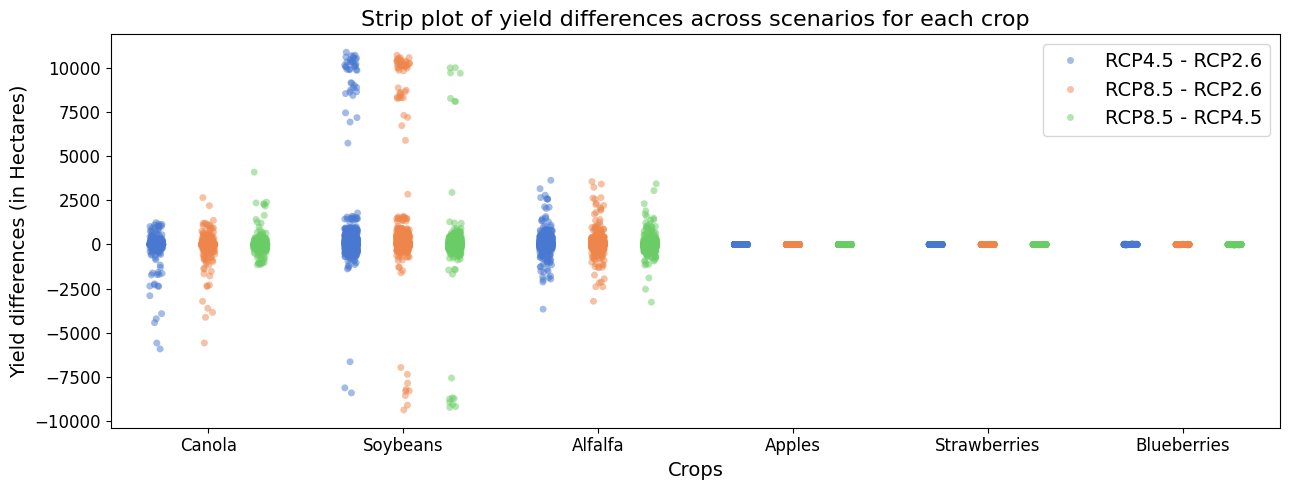

In [ ]:
# Plotting the strip plot for yield differences
crops = ['Canola', 'Soybeans', 'Alfalfa', 'Apples', 'Strawberries', 'Blueberries']
data = {}
for crop in crops:
    data[crop] = pd.read_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_{crop}.csv')

# Computing the differences
for crop in crops:
    data[crop]['Diff_4.5_2.6'] = data[crop]['Crop_yield_RCP45'] - data[crop]['Crop_yield_RCP26']
    data[crop]['Diff_8.5_2.6'] = data[crop]['Crop_yield_RCP85'] - data[crop]['Crop_yield_RCP26']
    data[crop]['Diff_8.5_4.5'] = data[crop]['Crop_yield_RCP85'] - data[crop]['Crop_yield_RCP45']

# Combining data into a single DataFrame with a new column for the scenario differences
combined_df = pd.concat([data[crop].assign(Crop=crop) for crop in crops])
combined_df_melted = combined_df.melt(id_vars=['Crop'], value_vars=['Diff_4.5_2.6', 'Diff_8.5_2.6', 'Diff_8.5_4.5'], var_name='Scenario', value_name='Yield Difference')

# Mapping scenario names to more readable format
scenario_labels = {
    'Diff_4.5_2.6': 'RCP4.5 - RCP2.6',
    'Diff_8.5_2.6': 'RCP8.5 - RCP2.6',
    'Diff_8.5_4.5': 'RCP8.5 - RCP4.5'
}
combined_df_melted['Scenario'] = combined_df_melted['Scenario'].map(scenario_labels)

plt.figure(figsize=(13, 5))

# Plotting the strip plot
sns.stripplot(data=combined_df_melted, x='Crop', y='Yield Difference', hue='Scenario', palette='muted', dodge=True, jitter=True, alpha=0.5)

plt.title('Strip plot of yield differences across scenarios for each crop', fontsize=16)
plt.xlabel('Crops', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Yield differences (in Hectares)', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Calculating absolute mean yield difference for each crop and scenario
combined_df_melted['Abs_Yield_Difference'] = combined_df_melted['Yield Difference'].abs()
abs_mean_yield_diff = combined_df_melted.groupby(['Crop', 'Scenario'])['Abs_Yield_Difference'].mean().reset_index()
abs_mean_yield_diff.columns = ['Crop', 'Scenario', 'Absolute mean yield difference']
print(abs_mean_yield_diff)

            Crop         Scenario  Absolute mean yield difference
0        Alfalfa  RCP4.5 - RCP2.6                      234.792048
1        Alfalfa  RCP8.5 - RCP2.6                      231.138406
2        Alfalfa  RCP8.5 - RCP4.5                      184.302619
3         Apples  RCP4.5 - RCP2.6                        0.151858
4         Apples  RCP8.5 - RCP2.6                        0.164259
5         Apples  RCP8.5 - RCP4.5                        0.132745
6    Blueberries  RCP4.5 - RCP2.6                        0.600253
7    Blueberries  RCP8.5 - RCP2.6                        0.401056
8    Blueberries  RCP8.5 - RCP4.5                        0.425163
9         Canola  RCP4.5 - RCP2.6                      139.049537
10        Canola  RCP8.5 - RCP2.6                      140.188063
11        Canola  RCP8.5 - RCP4.5                       95.696224
12      Soybeans  RCP4.5 - RCP2.6                      787.859091
13      Soybeans  RCP8.5 - RCP2.6                      885.867339
14      So

# Calculating yield differences between 2021 and 2026

In [ ]:
# Loading datasets
# Year 2021
All_variables_2021 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_2021.xlsx')
All_variables_2021 = All_variables_2021[['New_ID', 'CANOLA_M', 'SOYBNS_M', 'ALFALFA_M', 'APPLETA_M', 'STRWBTA_M', 'BLUEBTA_M']]

CCS_ID_chosen = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/CCS_ID.xlsx')
# Filtering rows in All_variables_2021 where 'New_ID' is in CCS_ID_chosen
All_variables_2021_new = All_variables_2021[All_variables_2021['New_ID'].isin(CCS_ID_chosen['New_ID'])]

All_variables_2021_new.loc[All_variables_2021_new['CANOLA_M'] == -1, 'CANOLA_M'] = 0
All_variables_2021_new.loc[All_variables_2021_new['SOYBNS_M'] == -1, 'SOYBNS_M'] = 0
All_variables_2021_new.loc[All_variables_2021_new['ALFALFA_M'] == -1, 'ALFALFA_M'] = 0
All_variables_2021_new.loc[All_variables_2021_new['APPLETA_M'] == -1, 'APPLETA_M'] = 0
All_variables_2021_new.loc[All_variables_2021_new['STRWBTA_M'] == -1, 'STRWBTA_M'] = 0
All_variables_2021_new.loc[All_variables_2021_new['BLUEBTA_M'] == -1, 'BLUEBTA_M'] = 0

# Year 2026
Canola_2026 = pd.read_csv('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_Canola.csv')
Soybeans_2026 = pd.read_csv('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_Soybeans.csv')
Alfalfa_2026 = pd.read_csv('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_Alfalfa.csv')
Apples_2026 = pd.read_csv('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_Apples.csv')
Strawberries_2026 = pd.read_csv('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_Strawberries.csv')
Blueberries_2026 = pd.read_csv('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_Blueberries.csv')

In [ ]:
# Identifying the CCS_ID in each province
Prov_CCS_ID = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Provinces_CCS_ID.xlsx')
Prov_CCS_ID.replace('<Null>', np.nan, inplace=True)
# Filtering rows in Prov_CCS_ID where 'New_ID' is in CCS_ID_chosen
Provinces_CCS_ID_BC = Prov_CCS_ID[Prov_CCS_ID['BC'].isin(CCS_ID_chosen['New_ID'])]
Provinces_CCS_ID_AB = Prov_CCS_ID[Prov_CCS_ID['AB'].isin(CCS_ID_chosen['New_ID'])]
Provinces_CCS_ID_MB = Prov_CCS_ID[Prov_CCS_ID['MB'].isin(CCS_ID_chosen['New_ID'])]
Provinces_CCS_ID_SK = Prov_CCS_ID[Prov_CCS_ID['SK'].isin(CCS_ID_chosen['New_ID'])]
Provinces_CCS_ID_ON = Prov_CCS_ID[Prov_CCS_ID['ON'].isin(CCS_ID_chosen['New_ID'])]
Provinces_CCS_ID_QC = Prov_CCS_ID[Prov_CCS_ID['QC'].isin(CCS_ID_chosen['New_ID'])]
Provinces_CCS_ID_NB = Prov_CCS_ID[Prov_CCS_ID['NB'].isin(CCS_ID_chosen['New_ID'])]
Provinces_CCS_ID_NS = Prov_CCS_ID[Prov_CCS_ID['NS'].isin(CCS_ID_chosen['New_ID'])]

# Identifying the CCS_ID in each province
# BC
New_ID_BC_unique = Provinces_CCS_ID_BC['BC'].unique()
New_ID_BC = New_ID_BC_unique[~np.isnan(New_ID_BC_unique)]

# AB
New_ID_AB_unique = Provinces_CCS_ID_AB['AB'].unique()
New_ID_AB = New_ID_AB_unique[~np.isnan(New_ID_AB_unique)]

# MB
New_ID_MB_unique = Provinces_CCS_ID_MB['MB'].unique()
New_ID_MB = New_ID_MB_unique[~np.isnan(New_ID_MB_unique)]

# SK
New_ID_SK_unique = Provinces_CCS_ID_SK['SK'].unique()
New_ID_SK = New_ID_SK_unique[~np.isnan(New_ID_SK_unique)]

# ON
New_ID_ON_unique = Provinces_CCS_ID_ON['ON'].unique()
New_ID_ON = New_ID_ON_unique[~np.isnan(New_ID_ON_unique)]

# QC
New_ID_QC_unique = Provinces_CCS_ID_QC['QC'].unique()
New_ID_QC = New_ID_QC_unique[~np.isnan(New_ID_QC_unique)]

# NB
New_ID_NB_unique = Provinces_CCS_ID_NB['NB'].unique()
New_ID_NB = New_ID_NB_unique[~np.isnan(New_ID_NB_unique)]

# NS
New_ID_NS_unique = Provinces_CCS_ID_NS['NS'].unique()
New_ID_NS = New_ID_NS_unique[~np.isnan(New_ID_NS_unique)]

In [ ]:
# Calculating the yield differences between the years 2021 and 2026 for each province
provinces = ['BC', 'AB', 'MB', 'SK', 'ON', 'QC', 'NB', 'NS']

total_diff_yield = {
    'Canola': {province: 0 for province in provinces},
    'Soybeans': {province: 0 for province in provinces},
    'Alfalfa': {province: 0 for province in provinces},
    'Apples': {province: 0 for province in provinces},
    'Strawberries': {province: 0 for province in provinces},
    'Blueberries': {province: 0 for province in provinces}
}

for province in provinces:
  New_IDs = globals()[f'New_ID_{province}']

  # Calculating yield differences for each crop in the current province
  for ind in New_IDs:
    # Canola
    canola_diff_yield_each_CCS = Canola_2026[Canola_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0] - All_variables_2021_new[All_variables_2021_new['New_ID'] == ind]['CANOLA_M'].values[0]
    total_diff_yield['Canola'][province] += canola_diff_yield_each_CCS

    # Soybeans
    soybeans_diff_yield_each_CCS = Soybeans_2026[Soybeans_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0] - All_variables_2021_new[All_variables_2021_new['New_ID'] == ind]['SOYBNS_M'].values[0]
    total_diff_yield['Soybeans'][province] += soybeans_diff_yield_each_CCS

    # Alfalfa
    alfalfa_diff_yield_each_CCS = Alfalfa_2026[Alfalfa_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0] - All_variables_2021_new[All_variables_2021_new['New_ID'] == ind]['ALFALFA_M'].values[0]
    total_diff_yield['Alfalfa'][province] += alfalfa_diff_yield_each_CCS

    # Apples
    apples_diff_yield_each_CCS = Apples_2026[Apples_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0] - All_variables_2021_new[All_variables_2021_new['New_ID'] == ind]['APPLETA_M'].values[0]
    total_diff_yield['Apples'][province] += apples_diff_yield_each_CCS

    # Strawberries
    strawberries_diff_yield_each_CCS = Strawberries_2026[Strawberries_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0] - All_variables_2021_new[All_variables_2021_new['New_ID'] == ind]['STRWBTA_M'].values[0]
    total_diff_yield['Strawberries'][province] += strawberries_diff_yield_each_CCS

    # Blueberries
    blueberries_diff_yield_each_CCS = Blueberries_2026[Blueberries_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0] - All_variables_2021_new[All_variables_2021_new['New_ID'] == ind]['BLUEBTA_M'].values[0]
    total_diff_yield['Blueberries'][province] += blueberries_diff_yield_each_CCS

# Printing the total yield differences for each crop in each province
for crop in total_diff_yield:
  for province in total_diff_yield[crop]:
    print(f'Total {crop.lower()} yield difference for {province}: {np.ceil(total_diff_yield[crop][province])}')
  print('_ '*30)

Total canola yield difference for BC: 382181.0
Total canola yield difference for AB: 58382.0
Total canola yield difference for MB: 39542.0
Total canola yield difference for SK: 174801.0
Total canola yield difference for ON: 905750.0
Total canola yield difference for QC: 1172357.0
Total canola yield difference for NB: 284411.0
Total canola yield difference for NS: 218463.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Total soybeans yield difference for BC: 933500.0
Total soybeans yield difference for AB: 221534.0
Total soybeans yield difference for MB: 491210.0
Total soybeans yield difference for SK: 1828392.0
Total soybeans yield difference for ON: 2122528.0
Total soybeans yield difference for QC: 273228.0
Total soybeans yield difference for NB: 42042.0
Total soybeans yield difference for NS: 5811.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Total alfalfa yield difference for BC: 151568.0
Total alfalfa yield difference for AB: -113514.0
Total alfalfa y

In [ ]:
# Calculating the yields for the year 2026 under the scenario RCP 8.5 for each province
provinces = ['BC', 'AB', 'MB', 'SK', 'ON', 'QC', 'NB', 'NS']

total_yield = {
    'Canola': {province: 0 for province in provinces},
    'Soybeans': {province: 0 for province in provinces},
    'Alfalfa': {province: 0 for province in provinces},
    'Apples': {province: 0 for province in provinces},
    'Strawberries': {province: 0 for province in provinces},
    'Blueberries': {province: 0 for province in provinces}
}

for province in provinces:
  New_IDs = globals()[f'New_ID_{province}']

  # Calculating yields for each crop in the current province
  for ind in New_IDs:
    # Canola
    canola_yield_each_CCS = Canola_2026[Canola_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0]
    total_yield['Canola'][province] += canola_yield_each_CCS

    # Soybeans
    soybeans_yield_each_CCS = Soybeans_2026[Soybeans_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0]
    total_yield['Soybeans'][province] += soybeans_yield_each_CCS

    # Alfalfa
    alfalfa_yield_each_CCS = Alfalfa_2026[Alfalfa_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0]
    total_yield['Alfalfa'][province] += alfalfa_yield_each_CCS

    # Apples
    apples_yield_each_CCS = Apples_2026[Apples_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0]
    total_yield['Apples'][province] += apples_yield_each_CCS

    # Strawberries
    strawberries_yield_each_CCS = Strawberries_2026[Strawberries_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0]
    total_yield['Strawberries'][province] += strawberries_yield_each_CCS

    # Blueberries
    blueberries_yield_each_CCS = Blueberries_2026[Blueberries_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0]
    total_yield['Blueberries'][province] += blueberries_yield_each_CCS

# Printing the total differences for each crop in each province
for crop in total_yield:
  for province in total_yield[crop]:
    print(f'Total {crop.lower()} yields for {province} is: {np.ceil(total_yield[crop][province])}')
  print('_ '*30)

Total canola yields for BC is: 422612.0
Total canola yields for AB is: 2680919.0
Total canola yields for MB is: 886514.0
Total canola yields for SK is: 3938055.0
Total canola yields for ON is: 910420.0
Total canola yields for QC is: 1177466.0
Total canola yields for NB is: 284740.0
Total canola yields for NS is: 218463.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Total soybeans yields for BC is: 933540.0
Total soybeans yields for AB is: 222161.0
Total soybeans yields for MB is: 756447.0
Total soybeans yields for SK is: 1839054.0
Total soybeans yields for ON is: 2887181.0
Total soybeans yields for QC is: 393608.0
Total soybeans yields for NB is: 44093.0
Total soybeans yields for NS is: 9793.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Total alfalfa yields for BC is: 291470.0
Total alfalfa yields for AB is: 868788.0
Total alfalfa yields for MB is: 191109.0
Total alfalfa yields for SK is: 709561.0
Total alfalfa yields for ON is: 273496.0
Total alfalfa y

#Assessing the importance of variables on yields for each crop type

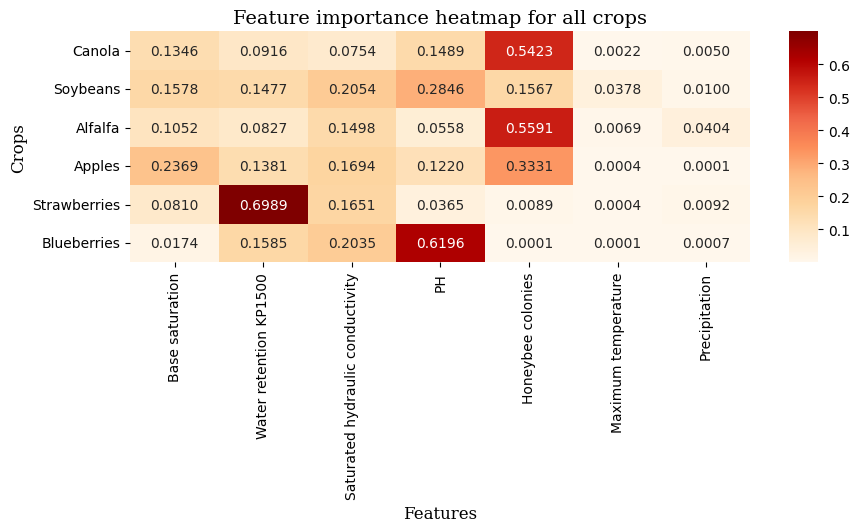

In [ ]:
# Initialize a DataFrame to store all feature importances
all_importances = pd.DataFrame()

Crops = ['Canola', 'Soybeans', 'Alfalfa', 'Apples', 'Strawberries', 'Blueberries']

for crop in Crops:
  if crop == 'Canola':
    X_training = X_Canola_train
    Y_training = Y_Canola_train
    optimized_n_estimators = 500
    optimized_max_depth = 21
  elif crop == 'Soybeans':
    X_training = X_Soybeans_train
    Y_training = Y_Soybeans_train
    optimized_n_estimators = 200
    optimized_max_depth = 5
  elif crop == 'Alfalfa':
    X_training = X_Alfalfa_train
    Y_training = Y_Alfalfa_train
    optimized_n_estimators = 200
    optimized_max_depth = 9
  elif crop == 'Apples':
    X_training = X_Apples_train
    Y_training = Y_Apples_train
    optimized_n_estimators = 300
    optimized_max_depth = 5
  elif crop == 'Strawberries':
    X_training = X_Strawberries_train
    Y_training = Y_Strawberries_train
    optimized_n_estimators = 200
    optimized_max_depth = 9
  elif crop == 'Blueberries':
    X_training = X_Blueberries_train
    Y_training = Y_Blueberries_train
    optimized_n_estimators = 500
    optimized_max_depth = 13

  # XGBoost
  XGBoost = xgb.XGBRegressor(n_estimators=optimized_n_estimators, max_depth = optimized_max_depth, random_state=42)
  XGBoost.fit(X_training, Y_training)

  # Getting feature importances
  importances = XGBoost.feature_importances_

  # Normalizing the importances to sum to 1
  importances = importances / importances.sum()

  # Creating a DataFrame for visualization
  importance_df = pd.DataFrame({
      'feature': Considered_variables_2021.drop(columns=['New_ID','Canola', 'Soybeans', 'Alfalfa', 'Apples', 'Strawberries',
                                                          'Blueberries'], axis=1).columns,
      crop: importances
  })

  # Appending the importances to the all_importances DataFrame
  if all_importances.empty:
    all_importances = importance_df
  else:
    all_importances = all_importances.merge(importance_df, on='feature')

# Setting feature as the index
all_importances.set_index('feature', inplace=True)

# Transposing the DataFrame for heatmap
importance_pivot = all_importances.T

# Plotting the heatmap using Seaborn library
plt.figure(figsize=(10, 3))
sns.heatmap(importance_pivot, annot=True, fmt='.4f', cmap='OrRd', cbar_kws={'aspect': 8})
plt.title('Feature importance heatmap for all crops', fontdict={'family': 'serif', 'weight': 'normal', 'size': 14})
plt.xlabel('Features', fontdict={'family': 'serif', 'weight': 'normal', 'size': 12})
plt.ylabel('Crops', fontdict={'family': 'serif', 'weight': 'normal', 'size': 12})
plt.xticks(rotation=90)
plt.show()